In [219]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

In [220]:
#исходные данные
data=pd.read_excel('mnt_rub.xlsx')
#первые разности
data['diff1']=data['Курс'].diff()
#вторые разности
data['diff2']=data['diff1'].diff()

In [221]:
p_value=adfuller(data['Курс'].dropna())
print('Исходные данные, p-value: ',p_value[1], ', уровень значимости: 0.05')
p_value_1=adfuller(data['diff1'].dropna())
print('Первые разности, p-value: ',p_value_1[1], ', уровень значимости: 0.05')
p_value_2=adfuller(data['diff2'].dropna())
print('Вторые разности, p-value: ',p_value_2[1], ', уровень значимости: 0.05')

Исходные данные, p-value:  0.5377956516387334 , уровень значимости: 0.05
Первые разности, p-value:  5.3214991604194345e-15 , уровень значимости: 0.05
Вторые разности, p-value:  1.701121850960935e-12 , уровень значимости: 0.05


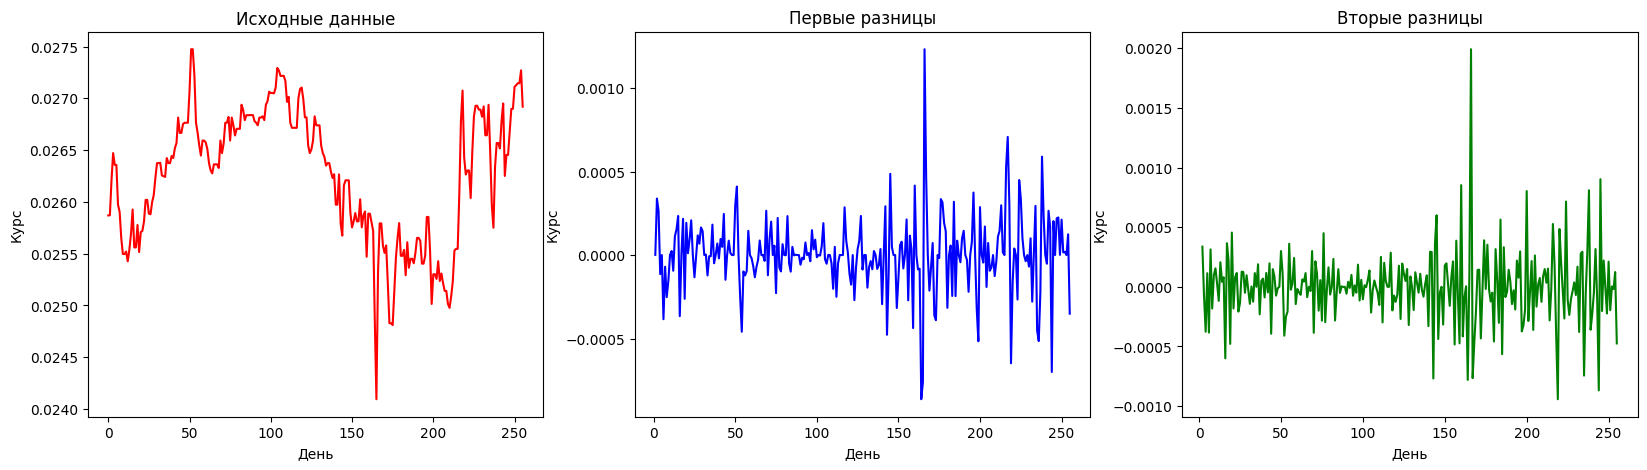

In [222]:
fig,axes=plt.subplots(1,3,figsize=(20,5))

axes[0].plot(data.index.values,data['Курс'],color='red',label='Исходные данные')
axes[0].set_title('Исходные данные')
axes[0].set_xlabel('День')
axes[0].set_ylabel('Курс')
axes[0].legend

axes[1].plot(data.index.values,data['diff1'],color='blue',label='Первые разницы')
axes[1].set_title('Первые разницы')
axes[1].set_xlabel('День')
axes[1].set_ylabel('Курс')
axes[1].legend

axes[2].plot(data.index.values,data['diff2'],color='green',label='Вторые разницы')
axes[2].set_title('Вторые разницы')
axes[2].set_xlabel('День')
axes[2].set_ylabel('Курс')
axes[2].legend

plt.show()

In [223]:
print(f'Значений в выборке {len(data)}')

# Определяем часть, отведённую для обучения
train_part = 9/10
#интервалы
intervals=[1/4,1/2,3/4,9/10]
end=[]
start=[]
cnt=0
for interval in intervals:
    end.append(int(train_part * len(data)))
    start.append(int (end[cnt] - interval * len(data)))
    print(f'\nОбучающая выборка: {interval}')
    print(f'Интервал: {start[cnt]} - {end[cnt] - 1}')
    cnt+=1

Значений в выборке 256

Обучающая выборка: 0.25
Интервал: 166 - 229

Обучающая выборка: 0.5
Интервал: 102 - 229

Обучающая выборка: 0.75
Интервал: 38 - 229

Обучающая выборка: 0.9
Интервал: 0 - 229


In [224]:
def find_harmonics(data,i,title):
    train_x = np.array(data)
    train_y = np.arange(0, len(data))
    # Выполнение дискретного преобразования Фурье
    fft_result = np.fft.rfft(train_x)
    # Получение амплитуды и частоты
    amplitude = np.abs(fft_result)
    frequency = np.fft.rfftfreq(len(data))
    #порог значимости
    threshold=0.3*np.max(amplitude[1:])
    #print(np.max(amplitude[1:]))
    #print(threshold)
    
    
    #print(frequency,amplitude)
    amp=[]
    harm=[]
    num_harm=[]
    
    for index,amp_ in enumerate(amplitude):
        #print(index,amp_)
        if amp_>threshold:
            amp.append(float(amp_))
            harm.append(float(frequency[index]))
            num_harm.append(index)
    harm=harm[1:]
    amp=amp[1:]
    num_harm=num_harm[1:]
    print('Кол-во значимых гармоник: ',len(harm))
    
    print(f'Частота: {frequency},Амплитуда: {amplitude}')
    #print(harm,amp)
    # Визуализация результатов
    plt.figure()
    plt.plot(frequency[1:], amplitude[1:])
    plt.scatter(harm,amp,color='red')
    plt.xlabel('Частота')
    plt.ylabel('Амплитуда')
    days = len(data)
    plt.title(f'Фурье ({title}), мерный интервал {intervals[i]}')
    plt.grid()
    plt.savefig(f'Фурье ({title}), мерный интервал {intervals[i]}.png')
    plt.close()
    return num_harm,harm,amp

In [225]:
def plot_all(x, y, legend, name, step_date=10):
    fig, ax = plt.subplots()
    ax.set_xlabel('date')
    ax.set_ylabel('y')
    ax.grid()
    for i in range(len(x)):
        plt.plot(x[i], y[i], label=legend[i])
    plt.legend(loc="upper left")
    plt.title(name)
    plt.savefig("{}.png".format(name))
    plt.close()

In [226]:
from scipy.fft import fft,fftfreq
from numpy import fft

def fourierExtrapolation(x, n_predict, harmonics):
    n = x.size
    n_harm = harmonics  # number of harmonics in model
    t = np.arange(0, n)
    p = np.polyfit(t, x, 1)  # find linear trend in x
    x_notrend = x - p[0] * t  # detrended x
    x_freqdom = fft.fft(x_notrend)  # detrended x in frequency domain
    f = fft.fftfreq(n)  # frequencies
    indexes = list(range(n))
    # sort indexes by frequency, lower -> higher
    indexes.sort(key=lambda i: np.absolute(f[i]))

    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(t.size)
    for i in indexes[:1 + n_harm * 2]:
        ampli = np.absolute(x_freqdom[i]) / n  # amplitude
        phase = np.angle(x_freqdom[i])  # phase
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
    return restored_sig + p[0] * t


Обучающая выборка: 0.25
Интервал: 166 - 229
Кол-во значимых гармоник:  5
Частота: [0.         0.01612903 0.03225806 0.0483871  0.06451613 0.08064516
 0.09677419 0.11290323 0.12903226 0.14516129 0.16129032 0.17741935
 0.19354839 0.20967742 0.22580645 0.24193548 0.25806452 0.27419355
 0.29032258 0.30645161 0.32258065 0.33870968 0.35483871 0.37096774
 0.38709677 0.40322581 0.41935484 0.43548387 0.4516129  0.46774194
 0.48387097 0.5       ],Амплитуда: [1.59069600e+00 1.35757255e-02 1.56388050e-02 6.16826511e-03
 3.96558223e-03 7.38018955e-03 5.04495764e-03 1.68186247e-03
 3.50620378e-03 3.12284939e-03 2.21722015e-03 2.27399738e-03
 3.28244836e-03 1.37567452e-04 5.46366717e-04 2.43350810e-03
 2.27422655e-03 1.86854788e-03 1.23213363e-03 2.35332339e-04
 4.95397649e-04 6.07781215e-04 4.75307818e-04 8.90062474e-04
 1.22502727e-03 7.74730542e-04 1.46985913e-03 3.24995227e-04
 1.01866355e-03 1.03479729e-03 5.75782008e-04 5.18000000e-04]
[1, 2, 3, 5, 6] [0.016129032258064516, 0.03225806451612903

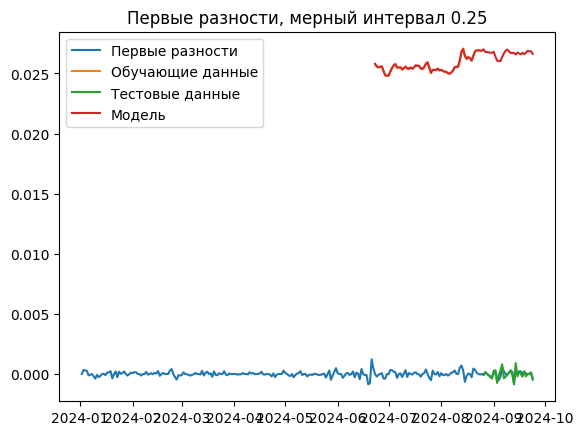


Обучающая выборка: 0.5
Интервал: 102 - 229
Кол-во значимых гармоник:  2
Частота: [0.         0.00793651 0.01587302 0.02380952 0.03174603 0.03968254
 0.04761905 0.05555556 0.06349206 0.07142857 0.07936508 0.08730159
 0.0952381  0.1031746  0.11111111 0.11904762 0.12698413 0.13492063
 0.14285714 0.15079365 0.15873016 0.16666667 0.17460317 0.18253968
 0.19047619 0.1984127  0.20634921 0.21428571 0.22222222 0.23015873
 0.23809524 0.24603175 0.25396825 0.26190476 0.26984127 0.27777778
 0.28571429 0.29365079 0.3015873  0.30952381 0.31746032 0.32539683
 0.33333333 0.34126984 0.34920635 0.35714286 0.36507937 0.37301587
 0.38095238 0.38888889 0.3968254  0.4047619  0.41269841 0.42063492
 0.42857143 0.43650794 0.44444444 0.45238095 0.46031746 0.46825397
 0.47619048 0.48412698 0.49206349 0.5       ],Амплитуда: [3.27580400e+00 5.10421732e-02 1.54345101e-02 1.40150351e-02
 8.97759098e-03 2.30142028e-03 3.36353837e-03 3.86142957e-03
 4.71048644e-03 4.59395346e-03 8.32500726e-03 5.07442148e-03
 3.56683

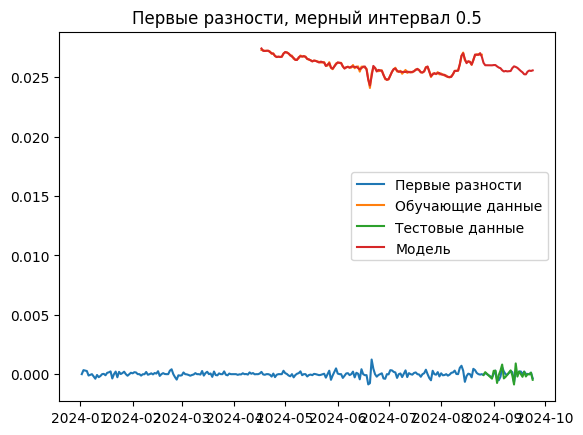


Обучающая выборка: 0.75
Интервал: 38 - 229
Кол-во значимых гармоник:  1
Частота: [0.         0.00526316 0.01052632 0.01578947 0.02105263 0.02631579
 0.03157895 0.03684211 0.04210526 0.04736842 0.05263158 0.05789474
 0.06315789 0.06842105 0.07368421 0.07894737 0.08421053 0.08947368
 0.09473684 0.1        0.10526316 0.11052632 0.11578947 0.12105263
 0.12631579 0.13157895 0.13684211 0.14210526 0.14736842 0.15263158
 0.15789474 0.16315789 0.16842105 0.17368421 0.17894737 0.18421053
 0.18947368 0.19473684 0.2        0.20526316 0.21052632 0.21578947
 0.22105263 0.22631579 0.23157895 0.23684211 0.24210526 0.24736842
 0.25263158 0.25789474 0.26315789 0.26842105 0.27368421 0.27894737
 0.28421053 0.28947368 0.29473684 0.3        0.30526316 0.31052632
 0.31578947 0.32105263 0.32631579 0.33157895 0.33684211 0.34210526
 0.34736842 0.35263158 0.35789474 0.36315789 0.36842105 0.37368421
 0.37894737 0.38421053 0.38947368 0.39473684 0.4        0.40526316
 0.41052632 0.41578947 0.42105263 0.42631579 0.

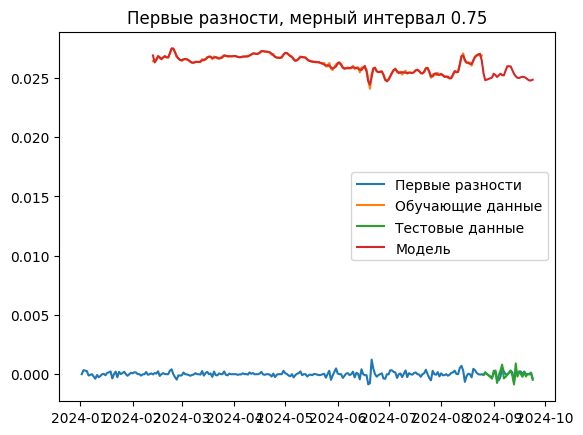


Обучающая выборка: 0.9
Интервал: 0 - 229
Кол-во значимых гармоник:  2
Частота: [0.         0.00438596 0.00877193 0.01315789 0.01754386 0.02192982
 0.02631579 0.03070175 0.03508772 0.03947368 0.04385965 0.04824561
 0.05263158 0.05701754 0.06140351 0.06578947 0.07017544 0.0745614
 0.07894737 0.08333333 0.0877193  0.09210526 0.09649123 0.10087719
 0.10526316 0.10964912 0.11403509 0.11842105 0.12280702 0.12719298
 0.13157895 0.13596491 0.14035088 0.14473684 0.14912281 0.15350877
 0.15789474 0.1622807  0.16666667 0.17105263 0.1754386  0.17982456
 0.18421053 0.18859649 0.19298246 0.19736842 0.20175439 0.20614035
 0.21052632 0.21491228 0.21929825 0.22368421 0.22807018 0.23245614
 0.23684211 0.24122807 0.24561404 0.25       0.25438596 0.25877193
 0.26315789 0.26754386 0.27192982 0.27631579 0.28070175 0.28508772
 0.28947368 0.29385965 0.29824561 0.30263158 0.30701754 0.31140351
 0.31578947 0.32017544 0.3245614  0.32894737 0.33333333 0.3377193
 0.34210526 0.34649123 0.35087719 0.35526316 0.3596

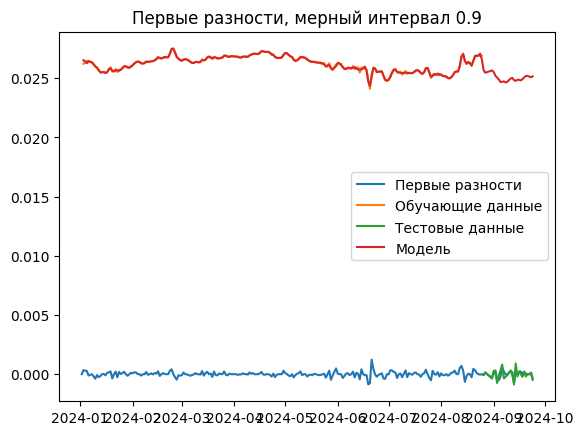

In [227]:
from sklearn.metrics import mean_squared_error

#x и y для преобразования фурье
train_y=[]
train_x=[]
test_x=[]
test_y=[]
#после преобразования
yf=[]
xf=[]

#амплитуды
amplitudes=[]
#порог значимости
treshold_ratio=0.2
#значимые
num_harm=[]
significant_harmonics=[]
significant_amplitudes=[]
#harmonics_list=[20,31,52,50]#для diff2
harmonics_list=[24,41,50,69]#для diff1
#harmonics_list=[5,2,1,2]#для исходного
harmonics_i=0
#проходимся по каждому мерному интервалу
for i in range(len(intervals)):
    print(f'\nОбучающая выборка: {intervals[i]}')
    print(f'Интервал: {start[i]} - {end[i] - 1}')
    
    #данные для разложения(тут меняем ряд)
    train_y.append(data[start[i]+2:end[i]]['Курс'].to_numpy())
    train_x.append(data[start[i]+2:end[i]]['Дата'].to_numpy())
    #тестовые данные
    test_y.append(data[end[i]:]['diff2'].to_numpy())
    test_x.append((data[end[i]:]['Дата'].to_numpy()))
    
    #поиск гармоник
    num_harm,significant_harmonics,significant_amplitudes=find_harmonics(train_y[i],i,'Исходные данные')
    
    print(num_harm,significant_harmonics,significant_amplitudes)
    
    
    harmonics=harmonics_list[harmonics_i]
    harmonics_i+=1
    
    n_predict=len(test_y[i])
    extrapolation=fourierExtrapolation(train_y[i], n_predict, harmonics)

    model_dates = np.concatenate([train_x[i], test_x[i]])
    
    #среднеквадратичное отклонение
    rmse = np.sqrt(mean_squared_error(train_y[i], extrapolation[:len(train_y[i])])) ** 0.5
    print(rmse)
    
    #средняя погрешность
    confidence_level = 0.95
    n=len(extrapolation)
    mean = np.mean(extrapolation)
    std_dev = np.std(extrapolation, ddof=1)
    z_value = 1.96
    margin_of_error = z_value * (std_dev / np.sqrt(n))
    
    print(margin_of_error)
    print(len(test_x[i]))
    #визуализация
    plt.plot(data['Дата'],data['diff1'],label='Первые разности')
    plt.plot(train_x[i],train_y[i],label='Обучающие данные')
    #print(train_x[i],test_x[i])
    plt.plot(test_x[i],test_y[i],label='Тестовые данные')
    plt.plot(model_dates,extrapolation,label='Модель')
    plt.legend()
    plt.title(f'Первые разности, мерный интервал {intervals[i]}')
    plt.show()